In [1]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


# FAQ / Common Issues

This was written on the original caffe SEGNET, with a Tesla K40 GPU. Caffe was compiled with cudnn version 3. This version of cudnn is not compatible with some newer GPUs.

* If you get bad results (poor accuracy, garbage, etc), your GPU may be too old. Try using [https://hub.docker.com/r/jfemiani/caffe_segnet_cudnn5/](jfemiani/caffe_segnet_cudnn5) which is a docker image with SEGNET on cudnn 5. 

# Fetch the evaluation / holdout data

In [2]:
eval_txt = '/data/traintest/i12/fold_01/eval.txt'
eval_files = [fn.strip() for fn in open(eval_txt).readlines()]
print "Found {} eval files".format(len(eval_files))

Found 293 eval files


The 'new' plan is to map a global `/data` to the location of the data files. This can be one easily with a docker volume command, which is how we do it. It can also be accomplished via a soft link on linux. This is better than assuming the data is in the current folder, since it is too big to store multiple times or commit to git, and symlinks do not commit. 

In [3]:
eval_files = [fn.replace('data/training/independant_12_layers', '/data/traintest/i12') for fn in eval_files]

In [4]:
cmp_eval_files = [f for f in eval_files if '/cmp/' in f]
print "Found", len(cmp_eval_files), "from the CMP dataset", len(eval_files)-len(cmp_eval_files), "are our own"

Found 175 from the CMP dataset 118 are our own


In [5]:
def show_images(images, nrows=4, ncols=4):
    for i in range(nrows*ncols):
        subplot(nrows, ncols, i+1)
        labeled_data = np.load(images[i])
        rgb = labeled_data[:3]
        features = labeled_data[3:]
        window  = features[1]
        imshow(rgb.transpose(1,2,0)/255.)
        xticks([]); yticks([])

<IPython.core.display.Javascript object>


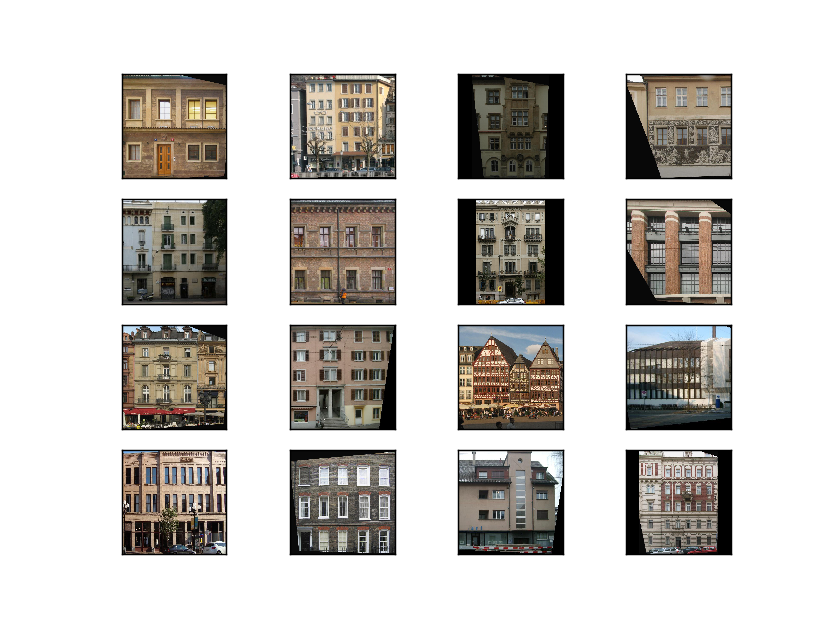

In [6]:
show_images(cmp_eval_files)

In [7]:
from pyfacades.util.metrics import Metrics

In [59]:
import pyfacades.util.metrics
reload(pyfacades.util.metrics)
Metrics = pyfacades.util.metrics.Metrics

In [8]:
LABELS= ['background', 'facade', 'window', 'door', 'cornice', 'sill',
         'balcony', 'blind', 'deco', 'molding', 'pillar', 'shop']

In [10]:
pyfacades.util.metrics!nvidia-smi

Tue Feb 20 16:56:26 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 387.26                 Driver Version: 387.26                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 20%   32C    P8    17W / 250W |    197MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 20%   28C    P8    16W / 250W |   6303MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

Before executing this next cell make sure you have acess to one of the GPU's. You will want one that nobody else is using. 

In [11]:
import caffe
#caffe.set_mode_cpu()
caffe.set_mode_gpu()
caffe.set_device(0)

For some reason, it seems like the terminal pauses partway through loading the moel. I have no idea why, but it can be resolved by switching over to the terminal that is running the notebook and hitting enter.

In general, whenever you run a caffe operation it is a good idea to pek at the terminal to see what it is spitting out. 

In [12]:
PROTO = 'non-bayesian-inference-net.prototxt'
#WEIGHTS = 'deploy/test_weights.caffemodel'
WEIGHTS = 'test_weights_from_peihao.caffemodel'
net = caffe.Net(PROTO, WEIGHTS, caffe.TEST)

# Set the batch size to one -- we are using the CPU
net.blobs['data'].reshape(1, 3, 512, 512)
net.reshape()

For each target in LABELS, we assign a label from this set (NEG, UNK, POS, EDGE).  

In [13]:
NEG = 0
UNK = 1
POS = 2
EDG = 3

In [14]:
LABELS

['background',
 'facade',
 'window',
 'door',
 'cornice',
 'sill',
 'balcony',
 'blind',
 'deco',
 'molding',
 'pillar',
 'shop']

The F1 score will depend on the amount of dilation. 
Right now the dilation is hardcoded as 3.
(This is done in the `Metrics` class)
We _should_ search for best value...

In [90]:
def softmax(a, axis=0):
    a = np.exp(a - a.max(axis=axis))
    a /= a.sum(axis=axis)
    return a

In [89]:
LABELS

['background',
 'facade',
 'window',
 'door',
 'cornice',
 'sill',
 'balcony',
 'blind',
 'deco',
 'molding',
 'pillar',
 'shop']

In [91]:
TARGET_NAME = 'window'
BACKGROUND=LABELS.index('background')

f = cmp_eval_files[9]

def get_metrics(f, target_name=TARGET_NAME, with_edges=True):
    blob = np.load(f)
    rgb = blob[:3]
    expected = blob[3:]  
    target_index = LABELS.index(target_name)
    expected_target = expected[target_index]
    expected_target[expected[BACKGROUND]==2] =1 # ignore
    
    # Remove padding from considereation
    # (Padding was added to work around a bug in caffe; every image needed at least one pixel that is not ignored.)
    padding = rgb.max(axis=0).max(axis=0) == 0
    padding = np.outer(np.ones(rgb.shape[1]), padding) > 0
    expected_target[padding] = 1
  
    net.forward(data=np.array([rgb]))
    predicted_probs = net.blobs['prob-'+target_name].data[0].squeeze()
   
    if with_edges is False:
        predicted_probs[(NEG, POS),:,:] = softmax(predicted_probs[(NEG, POS),:,:].copy())
        predicted_probs[EDG] = 0
    predicted_target = predicted_probs.argmax(0)

    #set_trace()
    mf = Metrics(expected=expected_target, 
                 predicted=predicted_target, 
                 label_positive=POS,
                 label_negative=NEG,
                 source=f,
                 feature=target_name
                )
    return mf, rgb, expected_target, predicted_target



<IPython.core.display.Javascript object>


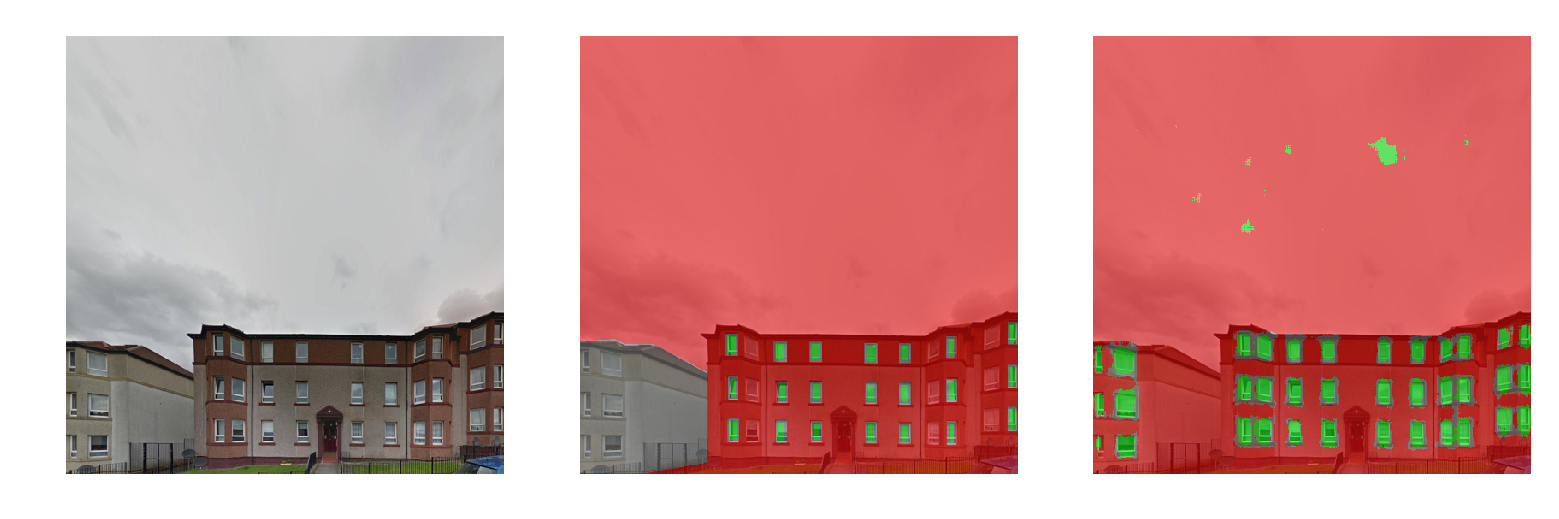

In [92]:
def visualize_eval(rgb, expected, predicted):       
    colors = array([[255, 0,   0],
                    [128, 128, 128], 
                    [0,   255, 0], 
                    [128, 128, 128]], dtype=np.uint8)
    subplot(131)
    imshow(rgb.transpose(1,2,0)/255.)
    axis('off')
    subplot(132)
    imshow(rgb.transpose(1,2,0)/255.)
    imshow(colors[expected.astype(int)], alpha=0.5)
    axis('off')
    subplot(133)
    imshow(rgb.transpose(1,2,0)/255.)
    imshow(colors[predicted.astype(int)], alpha=0.5)
    axis('off')
    tight_layout()
    
fig = figure(figsize=(12, 4))
visualize_eval(rgb, expected, predicted)

I do not _necessarily_ want to re-run the net for images I have already processed. I am using anydbm to check if the image has already been evaluated.

The way this works is this:
1. I create a database (key->value) and I associate each filename (the key) with the evaluation metrics for that file. The purpose of using anydb vs a python `dict` is that I do not want to lose the cache just because the server restarts. 
2. The metrics are calculated for all files in the evaluation set, if not already in the db, and their summary is displayed. 
3. I use the already-computed metrics to print a summary for _just_ the CMP images. 

In [93]:
import anydbm
import json
import hashlib
import munch

In [112]:
def compute_metrics(target_name, eval_files, recompute=True, visualize=False, cache=None):
    if cache is None:
        cache = {}
    elif recompute == True:
        cache.clear()

    if visualize:
        fig = figure(figsize=(12,4))

    total = Metrics(feature=target_name)
    for i, f in enumerate(eval_files):   
        if f not in eval_results:
            mf, rgb, expected, predicted = get_metrics(f)
            eval_results[f] = json.dumps(mf.as_dict())
            if visualize:
                visualize_eval(rgb, expected, predicted)
                try:
                    suptitle('{} of {}, $P$:{:.2%}, $R$:{:.2%}, $F_1$:{:.2%}, $A$:{:.2%}'.format(i, len(eval_files), total.pixel_precision, total.pixel_recall, total.pixel_f1, total.pixel_accuracy))
                except ZeroDivisionError:
                    suptitle("Not enough samples yet....")

                fig.canvas.draw()
        else:
            mf = Metrics(**json.loads(eval_results[f]))
        #print mf, 
        total += mf
    
    #print total
    print '\r{:3} of {}'.format(i, len(eval_files)),
    return total

In [113]:
cmp_total = compute_metrics(target_name='window', 
                            eval_files=cmp_eval_files,  
                            recompute=False,
                            cache=anydbm.open('eval_low_rank_'+TARGET_NAME, 'c'))


print cmp_total, 'Acc:', cmp_total.pixel_accuracy

from IPython.display import Latex
latex = r"""
\begin{{array}}{{ccccccc}}
Approach  & Acc & P & R & F_1 & P_{{obj}} & R_{{obj}} & F_{{1obj}}  \\
\hline
Separable & {acc:.2f} & {pixel_precision:.2f} & {pixel_recall:.2f} & {pixel_f1:.2f} & {object_precision:.2f} & {object_recall:.2f} & {object_f1:.2f}\\
\end{{array}}
""".format(acc=cmp_total.pixel_accuracy, **cmp_total.as_dict())

print latex
Latex(latex)

174 of 175 Metric(P=0.96, R=0.71, F=0.81,  OP=0.81, OR=0.72, OF=0.76) Acc: 0.958495924654

\begin{array}{ccccccc}
Approach  & Acc & P & R & F_1 & P_{obj} & R_{obj} & F_{1obj}  \\
\hline
Separable & 0.96 & 0.96 & 0.71 & 0.81 & 0.81 & 0.72 & 0.76\\
\end{array}



<IPython.core.display.Latex object>

<hr>

For an earlier version of this code, I did not keep track of the accuracy but only the precision (P) and recall (R). If we know the number of samples, it is possible to reverse-engineer an accuracy so that we can compare against others who report only accuaracy. 

I am confused about why people report accuracy for this imbalanced problem, and even skeptical that their numebrs are infact accuracy and not e.g. precision, but this is what we have to work with. 

In [ ]:
def reverse_engineer_acc(P, R):
    pos = 5988721
    neg = 57149895
    TP = R*pos
    FN = pos - TP
    FP = TP*(1.-P)/P
    TN = neg-FP
    acc = (TP+TN)/(TP+FP+TN+FN)
    return acc

In [ ]:
print '{:.1%}'.format(reverse_engineer_acc(0.73, 0.62))
print '{:.1%}'.format(reverse_engineer_acc(0.95, 0.69))
print '{:.1%}'.format(reverse_engineer_acc(0.91, 0.71))


# Find the top scores on CMP and GSV

In [ ]:
#%%file color_coded_errors.py

ERROR_COLORS = [[128, 128,  128], #TN
                [255, 0,    0],   #FP
                [0,   255,  0],   #TP
                [0,   0,    255], #FN
                [0,   0,    0], #ignored
               ]  
ERROR_COLORS = array(ERROR_COLORS, dtype=np.uint8)

def color_coded_errors(expected, predicted, ignored=None, colors=ERROR_COLORS):
    TP = ~ignored & (expected & predicted)
    FN = ~ignored & (expected & ~predicted)
    FP = ~ignored & (~expected & predicted)
    TN = ~ignored & (~expected & ~predicted)
    errors = np.argmax(array([TN, FP, TP, FN, ignored], dtype=np.uint8), axis=0)
    if colors is not None:
        return np.ma.masked_array(colors[errors], np.dstack([TN]*3))
    else:
        return errors  
      
def render_errors(path, alpha=0.5, noFN=True):
    mf, rgb, expected, predicted = get_metrics(path)
    ignored = (expected != mf.label_positive) & (expected != mf.label_negative)
    expected = expected==mf.label_positive
    predicted = predicted==mf.label_positive
    print mf.label_positive
    cc = color_coded_errors(expected, predicted, ignored)
    rgb = rgb.transpose(1,2,0)/255.
    if noFN:
        rgb[~cc.mask] = (1-alpha)*rgb[~cc.mask] + alpha*cc[~cc.mask]
        return rgb.clip(0,1)
        #imshow(predicted)
    else:
        rgb = (1-alpha)*rgb + alpha*cc
    return rgb

In [ ]:
def score(f):
    acc = Metrics(**json.loads(eval_results[f])).pixel_f1
    if isnan(acc):
        acc = 0
    return acc

In [ ]:
accs = array([score(f) for f in eval_files])

cmp_accs = array([accs[i] for i in range(len(eval_files))  if '/cmp/' in eval_files[i]])
cmp_files = array([eval_files[i] for i in range(len(eval_files))  if '/cmp/' in eval_files[i] ])

gsv_accs = array([accs[i] for i in range(len(eval_files)) if '/cmp/' not in eval_files[i] ] )
gsv_files = array([eval_files[i] for i in range(len(eval_files))  if '/cmp/' not in eval_files[i] ])

gsv_ranking = argsort(gsv_accs)
cmp_ranking = argsort(cmp_accs)

In [ ]:
figure()
plot(gsv_accs[gsv_ranking])

In [ ]:
%pdb off

In [ ]:
!nvidia-smi

In [ ]:
cmp_comparison_files = [cmp_files[cmp_ranking[-i-1]] for i in range(9)]

In [ ]:
f = cmp_comparison_files[0]

In [ ]:
f

In [ ]:
gsv_comparison_files = [gsv_files[gsv_ranking[-i-1]] for i in range(9)]
gsv_comparison_files[8]

In [ ]:
data = np.load(gsv_comparison_files[2])
rgb = data[:3]

figure()
imshow(rgb.transpose(1,2,0)/255)
imsave('gsv-example.png', rgb.transpose(1,2,0)/255)

In [ ]:
results = net.forward(data=array([rgb]))

In [ ]:
figure()
imshow(rgb.transpose(1,2,0)/255)

In [ ]:
colors = cm.nipy_spectral(linspace(0, 1, 13))[1:]

In [ ]:
from skimage.morphology import binary_closing, binary_opening

In [ ]:
def color_all(expected=None):
    cc = net.blobs['data'].data[0].transpose(1,2,0)/255
    labels = np.zeros(cc.shape[:2], dtype=int)
    for i, label in enumerate(LABELS):
        if i == 0:
            continue
        if expected is not None:
            mask = expected[i] == POS
        else:
            mask = net.blobs['label-'+label].data[0,0] == POS
        #mask = binary_closing(mask, selem=ones((5, 5)))
        #mask = binary_opening(mask, selem=ones((5, 5)))
        cc[mask] = colors[i][:3]
        labels[mask] = i
    return cc

In [ ]:
from skimage.measure import regionprops

In [ ]:
for i in range(9):
    data = np.load(gsv_comparison_files[i])
    rgb = data[:3]
    results = net.forward(data=array([rgb]))

    figure(figsize=(8, 3))
    subplot(131)
    imshow(rgb.transpose(1,2,0)/255)
    axis('off')
    subplot(132)
    imshow(rgb.transpose(1,2,0)/255)
    imshow(color_all(), alpha=0.75)
    axis('off')
    subplot(133)
    imshow(rgb.transpose(1,2,0)/255)
    imshow(color_all(data[3:]), alpha=0.75)
    axis('off')
    tight_layout()
    subplots_adjust(wspace=0.,hspace=0.)


In [ ]:
figure(figsize=(2, 6))
ax = gca()
w = 0.2
h = 0.05
for i, label in enumerate(LABELS):
    x = 0
    y = i*h
    R = Rectangle((x,y), w, h, fill=True, color=colors[i], alpha=1)
    ax.add_patch(R)
    text(x+w/2, y+h/2, label, horizontalalignment="center", verticalalignment="center")
ylim(0, len(LABELS)*h)
xlim(0,w)
axis('off')